In [1]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm 
import matplotlib.animation as anim

$\textbf{Colisiones 2D de duración finita}$

Como se evidenciará más adelante en la simulación, sí se trata de una fuerza conservativa, es decir, la energía total es constante. $K$ es una constante que nos permite clarificar las unidades. 

In [227]:
class Particle():
    
    def __init__(self, r0,v0,a0,t,m,radius,Id):
        
        self.dt  = t[1] - t[0]
        
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.rVector = np.zeros( (len(t),len(r0)) )
        self.vVector = np.zeros( (len(t),len(v0)) )
        self.aVector = np.zeros( (len(t),len(a0)) )
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        self.K=100.
        
        
        self.Ep_0=0
        self.Ek= np.zeros((len(t), 1))
        self.Ep= np.zeros((len(t), 1))
        
        self.Force= self.m*self.a
        
    def Evolution(self,i):
        
        self.SetPosition(i,self.r)
        self.SetVelocity(i,self.v)
        
        self.SetEk(i,self.GetEk())
        self.SetEp(i,self.GetEp())
        
        self.a= self.Force/self.m
        
        # Euler method
        self.r += self.dt * self.v
        self.v += self.dt * self.a
    
    def CheckWallLimits(self,limits,dim=2):
        
        for i in range(dim):
            
            if self.r[i] + self.radius > limits[i] and self.v[i]>0:
                self.v[i] = - self.v[i]
            if self.r[i] - self.radius < - limits[i] and self.v[i]< 0:
                self.v[i] = - self.v[i]
                
    def NullForce(self):
        self.Force[:]=0.
        self.a[:]=0.
        self.Ep_0=0.
        
    # Setters
    
    def SetPosition(self,i,r):
        self.rVector[i] = r
        
    def SetVelocity(self,i,v):
        self.vVector[i] = v
        
    def SetEk(self, i, Ek):
        self.Ek[i]= Ek
    
    def SetEp(self, i, Ep):
        self.Ep[i]= Ep
    
    def Collision(self, p):
        
        d=np.linalg.norm(self.r-p.GetPosition())
        c= self.radius+p.GetR() - d 
        
        if c > 0:
            F= self.K*(c**3)/d
            self.Force=np.add(self.Force,F*(self.r-p.GetPosition()))
            self.Ep_0+= self.K*c**4/4. #Integral hecha en los cálculos. 
            
    # Getters  
    def GetPosition(self):
        return self.r
    
    def GetPositionVector(self):
        return self.rVector
    
    def GetRPositionVector(self):
        return self.RrVector 

    def GetVelocityVector(self):
        return self.vVector
    
    def GetRVelocityVector(self):
        return self.RvVector
    
    def GetR(self):
        return self.radius
    
    def GetEk(self):
        return (0.5)*self.m*(np.linalg.norm(self.v)**2)
    
    def GetEp(self):
        return self.Ep_0/4.
    
    def GetForce(self):
        return self.Force
    
    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]]) 
        self.RvVector = np.array([self.vVector[0]]) 
        
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])
    

In [233]:
def GetParticles(t):
    Particles_=[]
    p1= Particle(np.array([-10.5,0.5]),np.array([20.,0.]),np.array([0.,0.]),t,1.,2.,0)
    p2= Particle(np.array([0.,-1.6]),np.array([0.,0.]),np.array([0.,0.]),t,1.,2.,1)
    p3= Particle(np.array([-15.,-15.]),np.array([0.,0.]),np.array([0.,0.]),t,1.,2.,1)
    
    Particles_.append(p1)
    Particles_.append(p2)
    Particles_.append(p3)
    
    return Particles_


In [212]:
Limits= np.array([20.,20.])

In [234]:
def RunSimulation(t):
    Particles= GetParticles(t)
    
    for it in tqdm(range(len(t))):
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i != j: #Garantizamos que la fuerza sea sobre bolas distintas
                    Particles[i].Collision(Particles[j])
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].NullForce()
            Particles[i].CheckWallLimits(Limits)
            
    return Particles


In [235]:
dt=0.01
tmax=8
t=np.arange(0,tmax,dt)
Particles=RunSimulation(t)

100%|██████████| 800/800 [00:00<00:00, 4247.54it/s]


In [231]:
def ReduceTime(t,factor):
    
    for p in Particles:
        p.ReduceSize(factor)
        
    Newt = []
    
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])
            
    return np.array(Newt)

In [237]:
redt = ReduceTime(t,10)

<IPython.core.display.Javascript object>


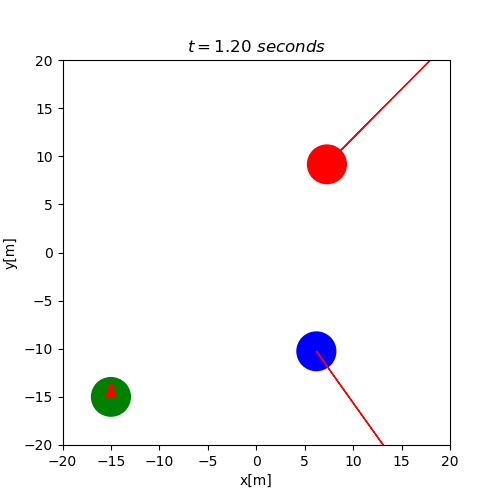

In [238]:
#Animacion

fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(1,1,1)

def init():
    ax.set_xlabel("x[m]")
    ax.set_ylabel("y[m]")
    ax.set_xlim(-Limits[0],Limits[0])
    ax.set_ylim(-Limits[1],Limits[1])

colors= ["r", "b", "g"]
def Update(i):
    plot= ax.clear()
    init()
    plot= ax.set_title(r"$t=%.2f \ seconds$" %(redt[i]))
    k=0
    for p in Particles:
        x = p.GetRPositionVector()[i,0]
        y = p.GetRPositionVector()[i,1]
        
        vx = p.GetRVelocityVector()[i,0]
        vy = p.GetRVelocityVector()[i,1]
        
        circle = plt.Circle( (x,y), p.GetR(), fill=True, color=colors[k])
        plot = ax.add_patch(circle)
        plot= ax.arrow(x,y,vx,vy,color="r", head_width=1.0)
        k+=1
    return plot
    
Animation= anim.FuncAnimation(fig,Update,frames=len(redt), init_func=init)

In [207]:
Writer = anim.writers['ffmpeg']
writer_ = Writer(fps=10, metadata=dict(artist='Me'))
Animation.save('colision2D.mp4', writer=writer_)

<IPython.core.display.Javascript object>


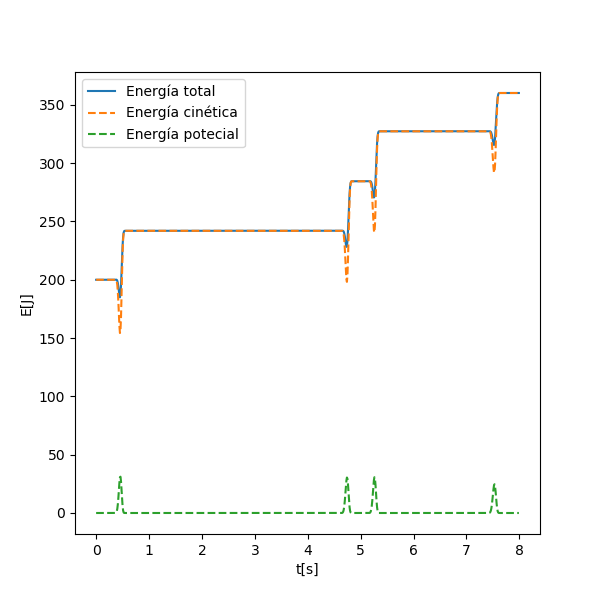

In [239]:
#Gráficas de energía 
fig2=plt.figure(figsize=(6,6))
ax2=fig2.add_subplot(1,1,1)

cinetica= Particles[0].Ek+Particles[1].Ek+Particles[2].Ek
potencial= Particles[0].Ep + Particles[1].Ep + Particles[2].Ep
total= np.add(cinetica,potencial)
ax2.plot(t, total, label="Energía total")
ax2.plot(t, cinetica, "--", label= "Energía cinética")
ax2.plot(t, potencial, "--", label="Energía potecial")
ax2.set_xlabel("t[s]")
ax2.set_ylabel("E[J]")
ax2.legend()
plt.savefig("grafica_energiacolision.jpg")

En teoría, la energía total debe mantenerse constante. Al parecer, tras cada choque hay un aumento de energía que no es claro de dónde proviene. Esto apunta a errores en la simulación que no pudieron ser identificados.